# TriMesh Guide

> [Trimesh](https://github.com/mikedh/trimesh) is a pure Python 3.7+ library for loading and using triangular meshes with an emphasis on watertight surfaces. The goal of the library is to provide a full featured and well tested Trimesh object which allows for easy manipulation and analysis, in the style of the Polygon object in the Shapely library.

The majority of examples and models used in this tutorial come from the official documentation.

Table of contents:

- [**1. Quickstart**](#1-quickstart)
- [2. Section](#2-section)
- [3. Colors](#3-colors)
- [4. Texture](#4-texture)
- [5. Rays and Intersections](#5-rays-and-intersections)
- [6. Nearest Points](#6-nearest-points)


In [6]:
MODELS_PATH = "../../trimesh/models"

## 1. Quickstart

Source: [https://trimesh.org/quick_start.html](https://trimesh.org/quick_start.html).

> A simple example showing various properties of Trimesh objects.

In [1]:
import numpy as np
import trimesh

In [2]:
# attach to logger so trimesh messages will be printed to console
#trimesh.util.attach_to_log()

In [3]:
# mesh objects can be created from existing faces and vertex data
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0]],
                       faces=[[0, 1, 2]])

In [4]:
# by default, Trimesh will do a light processing, which will
# remove any NaN values and merge vertices that share position
# if you want to not do this on load, you can pass `process=False`
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0]],
                       faces=[[0, 1, 2]],
                       process=False)

In [7]:
# load a file by name or from a buffer
mesh = trimesh.load_mesh(MODELS_PATH + '/featuretype.STL')
# to keep the raw data intact, disable any automatic processing
#mesh = trimesh.load_mesh(MODELS_PATH + '/featuretype.STL', process=False)

In [4]:
# is the current mesh watertight?
mesh.is_watertight

True

In [5]:
# what's the euler number for the mesh?
# https://en.wikipedia.org/wiki/Euler_characteristic
mesh.euler_number

-16

In [6]:
# the convex hull is another Trimesh object that is available as a property
# lets compare the volume of our mesh with the volume of its convex hull
np.divide(mesh.volume, mesh.convex_hull.volume)

0.7792407744466932

In [7]:
# since the mesh is watertight, it means there is a
# volumetric center of mass which we can set as the origin for our mesh
mesh.vertices -= mesh.center_mass

In [8]:
# what's the moment of inertia for the mesh?
mesh.moment_inertia

array([[ 6.93059627e+00, -1.43877613e-03, -1.49424850e-01],
       [-1.43877613e-03,  2.19191960e+01, -1.25194047e-04],
       [-1.49424850e-01, -1.25194047e-04,  2.62344872e+01]])

In [9]:
# if there are multiple bodies in the mesh we can split the mesh by
# connected components of face adjacency
# since this example mesh is a single watertight body we get a list of one mesh
mesh.split()

[<trimesh.Trimesh(vertices.shape=(1722, 3), faces.shape=(3476, 3), name=`featuretype.STL`)>]

In [10]:
# preview mesh in a pyglet window from a terminal, or inline in a notebook
mesh.show()

In [11]:
# facets are groups of coplanar adjacent faces
# set each facet to a random color
# colors are 8 bit RGBA by default (n,4) np.uint8
for facet in mesh.facets:
    mesh.visual.face_colors[facet] = trimesh.visual.random_color()

In [12]:
mesh.show()

In [13]:
# a random rotation matrix: H[R|t] with t = 0
trimesh.transformations.random_rotation_matrix()

array([[ 0.66222095, -0.67121091,  0.33307555,  0.        ],
       [ 0.70052915,  0.39682219, -0.59311977,  0.        ],
       [ 0.26593669,  0.62610547,  0.73298678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
# transform method can be passed a (4,4) matrix and will cleanly apply the transform
mesh.apply_transform(trimesh.transformations.random_rotation_matrix())

<trimesh.Trimesh(vertices.shape=(1722, 3), faces.shape=(3476, 3), name=`featuretype.STL`)>

In [15]:
# an axis aligned bounding box is available
mesh.bounding_box.primitive.extents

TrackedArray([4.81648354, 3.83403368, 3.92755244])

In [16]:
# a minimum volume oriented bounding box is available
mesh.bounding_box_oriented.primitive.extents

TrackedArray([1.375, 2.5  , 5.   ])

In [17]:
mesh.bounding_box_oriented.primitive.transform

TrackedArray([[-0.41867064, -0.02741052,  0.90772438, -0.05271956],
              [-0.70587105,  0.63869936, -0.30628285, -0.10324676],
              [-0.57136761, -0.768968  , -0.28675296, -0.08395718],
              [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
# the bounding box is a trimesh.primitives.Box object, which subclasses
# Trimesh and lazily evaluates to fill in vertices and faces when requested
mesh.bounding_box_oriented.show()

In [19]:
# show the mesh appended with its oriented bounding box
# the bounding box is a trimesh.primitives.Box object, which subclasses
# Trimesh and lazily evaluates to fill in vertices and faces when requested
# (press w in viewer to see triangles)
(mesh + mesh.bounding_box_oriented).show()

In [20]:
# bounding spheres and bounding cylinders of meshes are also
# available, and will be the minimum volume version of each
# except in certain degenerate cases, where they will be no worse
# than a least squares fit version of the primitive.
print(mesh.bounding_box_oriented.volume,
      mesh.bounding_cylinder.volume,
      mesh.bounding_sphere.volume)

17.187500000000018 33.79452095492218 95.89438997522063


## 2. Section

Source: [https://trimesh.org/section.html](https://trimesh.org/section.html).

> A demonstration of mesh-plane cross-sections, commonly referred to as “slicing” in the context of 3D printing.

In [21]:
import trimesh
import numpy as np
from shapely.geometry import LineString
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [22]:
# load the mesh from filename
# file objects are also supported
mesh = trimesh.load_mesh(MODELS_PATH + '/featuretype.STL')

In [23]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid,
                     plane_normal=[0,0,1])

In [24]:
# the section will be in the original mesh frame
slice.show()

## 3. Colors

Source: [https://trimesh.org/colors.html](https://trimesh.org/colors.html).

> A simple example of loading and displaying a mesh with face colors.

In [25]:
import trimesh

In [26]:
m = trimesh.load(MODELS_PATH + '/machinist.XAML',process=False)

In [27]:
m.visual.kind

'face'

In [28]:
m.show()

## 4. Texture

Source: [https://trimesh.org/texture.html](https://trimesh.org/texture.html).

> Load and display a mesh with UV coordinates and texture images.

In [29]:
import trimesh

In [31]:
mesh = trimesh.load(MODELS_PATH + '/fuze.obj')

In [32]:
mesh.show()

In [33]:
mesh.visual.uv.shape

(664, 2)

## 5. Rays and Intersections

Source: [https://trimesh.org/ray.html](https://trimesh.org/ray.html).

> An example showing simple ray-mesh queries.

In [8]:
import trimesh
import numpy as np

In [9]:
# test on a sphere primitive
mesh = trimesh.creation.icosphere()

In [10]:
# create some rays
ray_origins = np.array([[0, 0, -3],
                        [2, 2, -3]])
ray_directions = np.array([[0, 0, 1],
                           [0, 0, 1]])

In [11]:
# check out the docstring for intersects_location queries
mesh.ray.intersects_location.__doc__

'\n        Return the location of where a ray hits a surface.\n\n        Parameters\n        ----------\n        ray_origins : (n, 3) float\n          Origins of rays\n        ray_directions : (n, 3) float\n          Direction (vector) of rays\n\n        Returns\n        ---------\n        locations : (m) sequence of (p, 3) float\n          Intersection points\n        index_ray : (m,) int\n          Indexes of ray\n        index_tri : (m,) int\n          Indexes of mesh.faces\n        '

In [12]:
# run the mesh- ray query
locations, index_ray, index_tri = mesh.ray.intersects_location(
        ray_origins=ray_origins,
        ray_directions=ray_directions)

In [13]:
# the rays hit the mesh at coordinateslocations

In [14]:
# the rays with index_ray hit the triangles stored at mesh.faces[index_tri]len(index_ray)

In [15]:
# stack rays into line segments for visualization as Path3D
ray_visualize = trimesh.load_path(np.hstack((ray_origins,
                                             ray_origins + ray_directions*5.0)).reshape(-1, 2, 3))

In [16]:
# unmerge so viewer doesn't smooth
mesh.unmerge_vertices()
# make mesh white-ish
mesh.visual.face_colors = [255,255,255,255]
mesh.visual.face_colors[index_tri] = [255, 0, 0, 255]

In [17]:
# create a visualization scene with rays, hits, and mesh
scene = trimesh.Scene([mesh,
                       ray_visualize])

In [18]:
# show the visualization
scene.show()

## 6. Nearest Points

Source: [https://trimesh.org/nearest.html](https://trimesh.org/nearest.html).

> An example showing nearest point queries, sampling the volume of box primitives generated from the oriented bounds and using PointCloud objects for visualization.

In [19]:
import trimesh
import numpy as np

In [20]:
# load a large- ish PLY model with colors
mesh = trimesh.load(MODELS_PATH + '/cycloidal.ply')

In [21]:
# we can sample the volume of Box primitives
points = mesh.bounding_box_oriented.sample_volume(count=10)

In [22]:
# find the closest point on the mesh to each random point
(closest_points,
 distances,
 triangle_id) = mesh.nearest.on_surface(points)
# distance from point to surface of meshdistances

In [24]:
print(closest_points, distances, triangle_id)

[[ 1.38181798  1.41714472  0.89918825]
 [ 1.18067809 -0.1004119   1.55535603]
 [ 1.37548411  0.92417683  1.50811195]
 [ 1.76775396  1.32644904  1.50811195]
 [ 0.91724789  1.32400697  1.10186195]
 [ 0.72565679  0.13383354  1.10186195]
 [ 0.56251471  1.30607636  0.95112174]
 [ 1.63735339  0.66730399  1.22686195]
 [ 1.94226905 -0.03829567  1.90888745]
 [ 0.55820293  0.02556076  1.50811195]] [0.0256842  0.17391197 0.05145553 0.29478616 0.02673146 0.01704302
 0.01515314 0.00642439 0.19479828 0.30618288] [12284 19523 20184  1253 35259 35473 11198 34670 20318  1441]


In [26]:
# create a PointCloud object out of each (n,3) list of points
cloud_original = trimesh.points.PointCloud(points)
cloud_close    = trimesh.points.PointCloud(closest_points)

# create a unique color for each point
cloud_colors = np.array([trimesh.visual.random_color() for i in points])

# set the colors on the random point and its nearest point to be the same
cloud_original.vertices_color = cloud_colors
cloud_close.vertices_color    = cloud_colors

# create a scene containing the mesh and two sets of points
scene = trimesh.Scene([mesh,
                       cloud_original,
                       cloud_close])

# show the scene wusing
scene.show()

## 6. Shortest Path

Source: [https://trimesh.org/shortest.html](https://trimesh.org/shortest.html).

> Given a mesh and two vertex indices find the shortest path between the two vertices while only traveling along edges of the mesh using a distance-weighted graph search.

In [27]:
import trimesh
import numpy as np
import networkx as nx

In [28]:
# test on a sphere mesh
mesh = trimesh.primitives.Sphere()

In [29]:
# edges without duplication
edges = mesh.edges_unique

In [30]:
# the actual length of each unique edge
length = mesh.edges_unique_length

In [31]:
# create the graph with edge attributes for length
g = nx.Graph()
for edge, L in zip(edges, length):
    g.add_edge(*edge, length=L)

In [32]:
# arbitrary indices of mesh.vertices to test with
start = 0
end = int(len(mesh.vertices) / 2.0)

In [33]:
# run the shortest path query using length for edge weight
path = nx.shortest_path(g,
                        source=start,
                        target=end,
                        weight='length')

In [34]:
# VISUALIZE RESULT
# make the sphere white
mesh.visual.face_colors = [255,255,255,255]
# Path3D with the path between the points
path_visual = trimesh.load_path(mesh.vertices[path])

In [35]:
# create a scene with the mesh, path, and points
scene = trimesh.Scene([path_visual, mesh ])

In [38]:
scene.show()

## 7. Curvature

Source: [https://trimesh.org/curvature.html](https://trimesh.org/curvature.html).

> An example of the discrete gaussian curvature measure.

In [39]:
import trimesh
from trimesh.curvature import discrete_gaussian_curvature_measure, discrete_mean_curvature_measure, sphere_ball_intersection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

mesh = trimesh.creation.icosphere()

In [40]:
radii = np.linspace(0.1, 2.0, 10)
gauss = np.array([discrete_gaussian_curvature_measure(mesh, mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])
mean = np.array([discrete_mean_curvature_measure(mesh, mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])

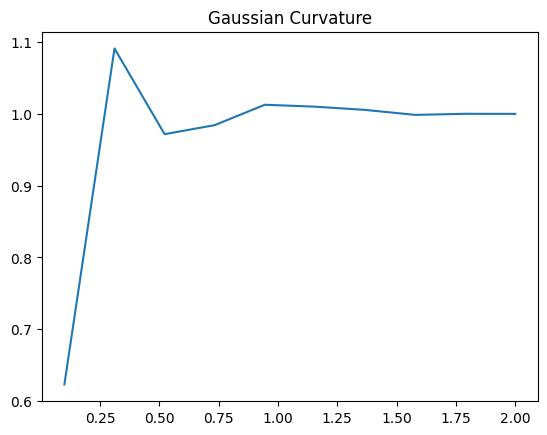

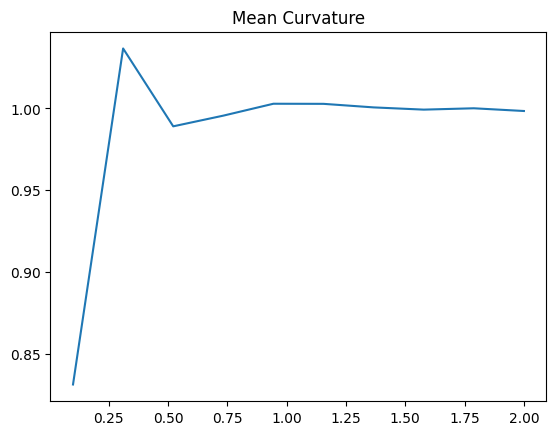

In [41]:
plt.figure()
plt.plot(radii, gauss.mean(axis=1))
plt.title('Gaussian Curvature')
plt.show()
plt.figure()
plt.plot(radii, mean.mean(axis=1))
plt.title('Mean Curvature')
plt.show();